In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mplfinance as mpf
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import datetime

import random

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from setup import get_task_data
from consts import TASK_2_DATA

In [2]:
financial_data = {}
metadata = {}

for filepath, sector in TASK_2_DATA.items():
    stock = filepath.split('.')[0]

    financial_data[stock] = pd.read_csv(get_task_data(filepath))
    metadata[stock] = sector 

Our financial data is supplied with metadata: name of a stock and financial sector it belongs too

Sectors:
* Technology - category of stocks relating to the research, development, or distribution of technologically based goods and services
* BasicMaterials - category made up of businesses engaged in the discovery, development, and processing of raw materials 
* Communications - category made up of services such as social media companies, Internet search firms, video game makers, telecom providers, and streaming media make up most of this sector
* Cyclical - category of stocks that rely heavily on the business cycle and economic conditions. Consumer cyclicals include industries such as automotive, housing, entertainment, and retail
* ConsumerDefensive - category of companies that manufacture food, beverages, household and personal products, packaging, or tobacco. Also includes companies that provide services such as education and training services
* Energy - category of companies that play a role in extracting, refining, or producing sources of energy
* Financial - category of firms and institutions that provide financial services to commercial and retail customers
* Healthcare - category of businesses that provide medical services, manufacture medical equipment or drugs, provide medical insurance, or otherwise facilitate the provision of healthcare to patients
* Industrial - category of businesses that aid other businesses in manufacturing, shipping or producing their products
* RealEstate - category of the following: Industrial, Office, Mixed-Industrial/Office, Retail-Shopping Centers, Retail-Regional Malls, Retail-Free Standing, Residential-Apartments, Residential-Manufactured Homes, Diversified, Lodging/Resorts, Health Care, Self Storage, Specialty, Home Financing and Commercial Financing
* Utilities - category of companies that provide their customers with electricity, water, and other public utilities

In [3]:
df = pd.DataFrame(data=metadata.items(), columns=['Stock', 'Sector'])
df.sample(15)

,Stock,Sector
22,BIDU,Communications
0,AMD,Technology
49,AZN,Healthcare
4,TSM,Technology
54,HON,Industrial
18,NFLX,Communications
10,SHW,BasicMaterials
33,PM,ConsumerDefensive
45,BX,Financial
12,SCCO,BasicMaterials


1. Classification

Model that predicts the sector company belongs to given the sequence of trades

RNN classification

In [4]:
classification_data = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
tail_length = 1024

for stock, data in financial_data.items():
    classification_data[stock] = data['Close'].tail(tail_length).to_numpy()

In [5]:
classes = df['Sector'].unique()
classes_count = len(classes)

print(classes)
print(classes_count)

['Technology' 'BasicMaterials' 'Communications' 'Cyclical'
 'ConsumerDefensive' 'Energy' 'Financial' 'Healthcare' 'Industrial'
 'RealEstate' 'Utilities']
11


In [6]:
classification_df = pd.DataFrame(data=classification_data.items(), columns=['Stock', 'CloseValues'])
classification_df = classification_df.merge(df, on='Stock', how='left')

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')
sectors = classification_df['Sector'].to_numpy().reshape(-1, 1)
enc.fit(sectors)

classification_df['Sector'] = enc.transform(sectors).toarray().tolist()

In [8]:
classification_df.sample(1)

,Stock,CloseValues,Sector
17,TMUS,"[79.959999, 79.360001, 79.809998, 79.0, 77.559...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Values of close prices represented as a sequence and sector as one-hot vector

In [9]:
classification_train_df, classification_test_df = train_test_split(classification_df, test_size=0.2)

In [10]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, input_shape=(None, 1024), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(classes_count, activation='softmax', name='output')
])

In [11]:
classification_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [12]:
x_train = np.array(classification_train_df['CloseValues'].tolist()).reshape(56, 1, 1024)
y_train = np.array(classification_train_df['Sector'].tolist()).reshape(56, 11)

x_test = np.array(classification_test_df['CloseValues'].tolist()).reshape(14, 1, 1024)
y_test = np.array(classification_test_df['Sector'].tolist()).reshape(14, 11)

In [13]:
early_stopping = EarlyStopping(patience = 15, monitor='loss')
classification_history = classification_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[early_stopping])

Epoch 1/100


d:\conda\envs\imta\lib\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 12s 2s/step - loss: 2.3955 - accuracy: 0.0893 - val_loss: 2.4027 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 1s 294ms/step - loss: 2.3306 - accuracy: 0.2321 - val_loss: 2.4124 - val_accuracy: 0.0714
Epoch 3/100
2/2 [==============================] - 1s 314ms/step - loss: 2.2925 - accuracy: 0.2857 - val_loss: 2.4131 - val_accuracy: 0.0714
Epoch 4/100
2/2 [==============================] - 1s 309ms/step - loss: 2.2645 - accuracy: 0.2857 - val_loss: 2.4065 - val_accuracy: 0.0714
Epoch 5/100
2/2 [==============================] - 1s 304ms/step - loss: 2.2236 - accuracy: 0.2679 - val_loss: 2.4100 - val_accuracy: 0.0714
Epoch 6/100
2/2 [==============================] - 1s 314ms/step - loss: 2.1786 - accuracy: 0.3571 - val_loss: 2.4339 - val_accuracy: 0.0714
Epoch 7/100
2/2 [==============================] - 1s 304ms/step - loss: 2.1397 - accuracy: 0.3393 - val_loss: 2.4391 - val_accuracy: 0.0714
Epoch 8/100
2/2 [==========

In [14]:
test_loss, test_acc = classification_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 38ms/step - loss: 2.4898 - accuracy: 0.3571
Test Loss: 2.4898288249969482
Test Accuracy: 0.3571428656578064


In [15]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(pad=5.0)

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0, 1])

    ax[1].plot(history.history['loss'], label='accuracy')
    ax[1].plot(history.history['val_loss'], label='val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_ylim([0, 3])

    plt.show()

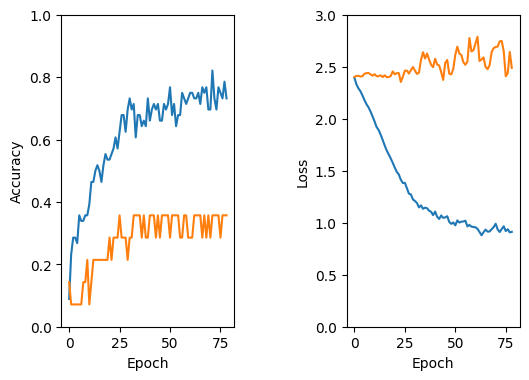

In [16]:
plot_history(classification_history)

2. Clusterization

Model that divides data into clusters, that expected to be close to it's sectors

Probably the best approach is to pack the vector of close values into matrix and clusterize them. 

3. Regression

Model that predicts next close price of a stock given the sequence of previous trades

RNN regression